# Character-Based Neural Language Model

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Install Dependencies

In [138]:
!pip install tensorflow_text -q
!pip install wandb -q

Proceed (y/n)? y
     |████████████████████████████████| 380.8MB 24kB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_text as tftext
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, Input, InputLayer, Lambda, LSTM
from tensorflow.keras.layers import InputSpec, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime, os
import wandb
import re

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "No GPUs found."

## Tracking setup

Login to your W&B account to track the model metrics and save progress.

In [4]:
wandb.login()

True

Initialize a new W&B run with:

* *entity* — the team posting this run (your username)
* *project* — the name of the project to which this run will belong

In [5]:
wandb.init(entity = "dzlab", project = "tf-char-rnn")

W&B Run: https://app.wandb.ai/dzlab/tf-char-rnn/runs/pav449pe

In [0]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 1024         #@param Input batch size for training
config.train_split = 0.8       #@param Train / Validation dataset split
config.seq_len = 40            #@param Length of character sequence to use for predicting the next character
config.embed_output = 100      #@param Ouput size of the Embedding layer
config.lstm_output_1 = 128     #@param Ouput size of 1st LSTM
config.lstm_output_2 = 128     #@param Ouput size of 2nd LSTM

In [0]:
batch_size, seq_len, train_split = 1024, 40, 0.8
embed_output, lstm_output_1, lstm_output_2 = 100, 128, 128

## Data
Elon Musk Tweets [Dataset](https://data.world/adamhelsinger/elon-musk-tweets-until-4-6-17), you can find more Twitter dataset [here](https://github.com/shaypal5/awesome-twitter-data).

In [0]:
# Make sure Pandas does not truncate columns in order to see all text
pd.set_option('display.max_colwidth', -1)

In [9]:
dataset = 'https://query.data.world/s/zo3rtfsdt5gfdy7k7hvas3e7ixudxp'
df = pd.read_csv(dataset)
df.head()

,id,created_at,text
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https://t.co/v7JUJQWfCv'
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl"""
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
3,848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat gas fracking. It's basically dead."""


In [0]:
size = df.count()[0]

### Text Cleaning

If you noticed, the text is encapsulated in a `b'...'`, we need to remove the starting token `b'` or `b"` and the endoing quotes `'` and `"`.

In [11]:
df['text'] = df['text'].apply(lambda text: re.sub("^b'|^b\"|'$|\"$", '', text))
df.head()

,id,created_at,text
0,849636868052275200,2017-04-05 14:56:29,And so the robots spared humanity ... https://t.co/v7JUJQWfCv
1,848988730585096192,2017-04-03 20:01:01,"@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl"
2,848943072423497728,2017-04-03 16:59:35,"@waltmossberg @mims @defcon_5 Et tu, Walt?"
3,848935705057280001,2017-04-03 16:30:19,Stormy weather in Shortville ...
4,848416049573658624,2017-04-02 06:05:23,@DaveLeeBBC @verge Coal is dying due to nat gas fracking. It's basically dead.


In [12]:
!curl -O https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  2723k      0 --:--:-- --:--:-- --:--:-- 2716k


In [0]:
text = ''.join(open('input.txt', 'r').readlines()) # shakespear

In [0]:
text = '\n'.join(df['text']) # tweets

In [0]:
text = """Sing a song of sixpence, A pocket full of rye.
Four and twenty blackbirds, Baked in a pie.
When the pie was opened The birds began to sing; Wasn't that a dainty dish, To set before the king.
The king was in his counting house, Counting out his money;
The queen was in the parlour, Eating bread and honey.
The maid was in the garden, Hanging out the clothes, When down came a blackbird And pecked off her nose."""

### Vocabulary
Create a character vocabulary

In [0]:
text_tensor = tf.constant(text)
chars_raged_tensor = tf.strings.unicode_split(text_tensor, 'UTF-8')

In [59]:
chars = chars_raged_tensor.numpy()
vocab = list(set(sorted(chars)))
print(vocab)

[b'\n', b'q', b'v', b'K', b'e', b'u', b':', b'N', b'w', b'E', b'U', b'd', b't', b'-', b'k', b'y', b'c', b's', b'h', b'G', b',', b'!', b'T', b' ', b'J', b'V', b'o', b'Z', b'P', b'j', b'W', b'l', b'I', b'r', b'g', b'X', b'p', b'A', b'a', b'C', b'&', b"'", b'M', b'z', b'L', b'f', b'H', b'O', b'R', b'F', b'.', b'3', b'S', b'?', b'b', b'x', b'B', b'Y', b'i', b'$', b'Q', b'n', b'm', b'D', b';']


### Build lookup table
Create a token-index mapping to use when encode review text into something that can be processed by a neural network.

In [0]:
def create_vocab_table(vocab, num_oov=1):
  """Create a lookup table for a vocabulary"""
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=vocab_values, key_dtype=tf.string, value_dtype=tf.int64)
  vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)
  return vocab_table

In [0]:
vocab_table = create_vocab_table(vocab)

In [62]:
vocab_table.lookup(tf.constant("\n"))

<tf.Tensor: id=83151, shape=(), dtype=int64, numpy=0>

### Create Dataset

In [0]:
sequences = tftext.ngrams(chars_raged_tensor, width=seq_len+1, reduction_type=tftext.Reduction.STRING_JOIN, string_separator='')

In [64]:
sequences[:5]

<tf.Tensor: id=83322, shape=(5,), dtype=string, numpy=
array([b'First Citizen:\nBefore we proceed any furt',
       b'irst Citizen:\nBefore we proceed any furth',
       b'rst Citizen:\nBefore we proceed any furthe',
       b'st Citizen:\nBefore we proceed any further',
       b't Citizen:\nBefore we proceed any further,'], dtype=object)>

Expand the string sequences one dimension

In [0]:
sequences = tf.expand_dims(sequences, -1)

In [0]:
train_size = int(len(sequences) * train_split)
valid_size = len(sequences) - train_size

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(sequences[:train_size])
valid_ds = tf.data.Dataset.from_tensor_slices(sequences[train_size:])

### Preprocessing
Create a preprocessing helper function which will be called on each sample in order to encode the tweets into a sequence of token indices.

The output of this transformation is a RaggedTensor.

In [0]:
@tf.function
def basic_preprocess(text):
  rt = tf.strings.unicode_split(text, 'UTF-8')
  rt = tf.ragged.map_flat_values(vocab_table.lookup, rt)
  features, labels = rt[..., :-1], rt[..., -1:]
  # in features, sequeeze the second from the last dimension as it was created by the spit
  features = tf.squeeze(features, axis=-2)
  # in labels, sequeeze the last dimension
  labels = tf.squeeze(labels, axis=-1)
  # make labels a regular tensor
  labels = labels.to_tensor()
  return features, labels

In [0]:
train_ds = train_ds.shuffle(train_size).batch(batch_size).map(basic_preprocess)
valid_ds = valid_ds.shuffle(valid_size).batch(batch_size).map(basic_preprocess)

In [70]:
train_examples_batch, train_labels_batch = next(iter(train_ds))
train_examples_batch.shape, train_labels_batch.shape

(TensorShape([1024, None]), TensorShape([1024, 1]))

In [71]:
train_examples_batch[:2], train_labels_batch[:2]

(<tf.RaggedTensor [[31, 36, 23, 12, 26, 23, 16, 33, 38, 2, 4, 20, 23, 38, 61, 11, 23, 62, 15, 23, 11, 4, 38, 33, 23, 18, 38, 36, 23, 12, 26, 23, 12, 4, 31, 31, 50, 0, 0, 49], [18, 26, 5, 23, 8, 58, 31, 12, 23, 45, 38, 31, 31, 23, 54, 38, 16, 14, 8, 38, 33, 11, 23, 8, 18, 4, 61, 23, 12, 18, 26, 5, 23, 18, 38, 17, 12, 23, 62, 26]]>,
 <tf.Tensor: id=83885, shape=(2, 1), dtype=int64, numpy=
 array([[48],
        [33]])>)

In [72]:
train_examples_batch[0]

<tf.Tensor: id=83908, shape=(40,), dtype=int64, numpy=
array([31, 36, 23, 12, 26, 23, 16, 33, 38,  2,  4, 20, 23, 38, 61, 11, 23,
       62, 15, 23, 11,  4, 38, 33, 23, 18, 38, 36, 23, 12, 26, 23, 12,  4,
       31, 31, 50,  0,  0, 49])>

In [0]:
# list(map(lambda idx: vocab[idx], train_examples_batch[0].numpy()))

## Model

In [0]:
pad_val, vocab_size = len(vocab), len(vocab)+1

### W&B Callback

In [0]:
wandb_callback = wandb.keras.WandbCallback(log_weights=True)

### Char-RNN

How to Quickly Train a Text-Generating Neural Network for Free [article](https://minimaxir.com/2018/05/text-neural-networks/).

#### AttentionWeightedAverage
An attention layer on the ouput of previous RNN layers as well as the Embedding layer. The implentation is based on this [](https://gist.github.com/thomwolf/e309e779a08c1ba899514d44355cd6df)

In [0]:
import tensorflow.keras.backend as K

class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = tf.initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_attention': self.return_attention
        })
        return config

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        #self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / K.sum(ai, axis=1, keepdims=True)
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

#### Build the model

As our targets are integers, we use `sparse_categorical_crossentropy` loss function.

In [0]:
input = Input(shape=(None,), dtype='int64', ragged=True)
dense = tftext.keras.layers.ToDense(pad_value=pad_val, mask=True)(input)
embed = Embedding(vocab_size, config.embed_output)(dense)
lstm1 = LSTM(config.lstm_output_1, return_sequences=True)(embed)
lstm2 = LSTM(config.lstm_output_2, return_sequences=True)(lstm1)
concat = Concatenate(axis=-1)([embed, lstm1, lstm2])
attn = AttentionWeightedAverage()(concat)
output = Dense(vocab_size, activation='softmax')(attn)
model = Model(inputs=[input], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [79]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
to_dense_2 (ToDense)            (None, None)         0           input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    6600        to_dense_2[0][0]                 
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, None, 128)    117248      embedding_2[0][0]                
____________________________________________________________________________________________

In [80]:
model.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[wandb_callback])

Epoch 1/10
      1/Unknown - 4s 4s/step - loss: 4.1892 - accuracy: 0.0107WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.126718). Check your callbacks.
872/872 [==============================] - 61s 70ms/step - loss: 2.9052 - accuracy: 0.2249 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
872/872 [==============================] - 49s 56ms/step - loss: 2.0923 - accuracy: 0.3890 - val_loss: 2.0522 - val_accuracy: 0.3943
Epoch 3/10
872/872 [==============================] - 49s 56ms/step - loss: 1.8945 - accuracy: 0.4419 - val_loss: 1.9427 - val_accuracy: 0.4257
Epoch 4/10
872/872 [==============================] - 49s 56ms/step - loss: 1.7718 - accuracy: 0.4759 - val_loss: 1.8682 - val_accuracy: 0.4536
Epoch 5/10
872/872 [==============================] - 49s 56ms/step - loss: 1.6852 - accuracy: 0.5001 - val_loss: 1.8334 - val_accuracy: 0.4664
Epoch 6/10
872/872 [==============================] - 49s 56ms/step - loss: 1.6198 - accurac

In [0]:
model.save(os.path.join(wandb.run.dir, "char-rnn.h5"))

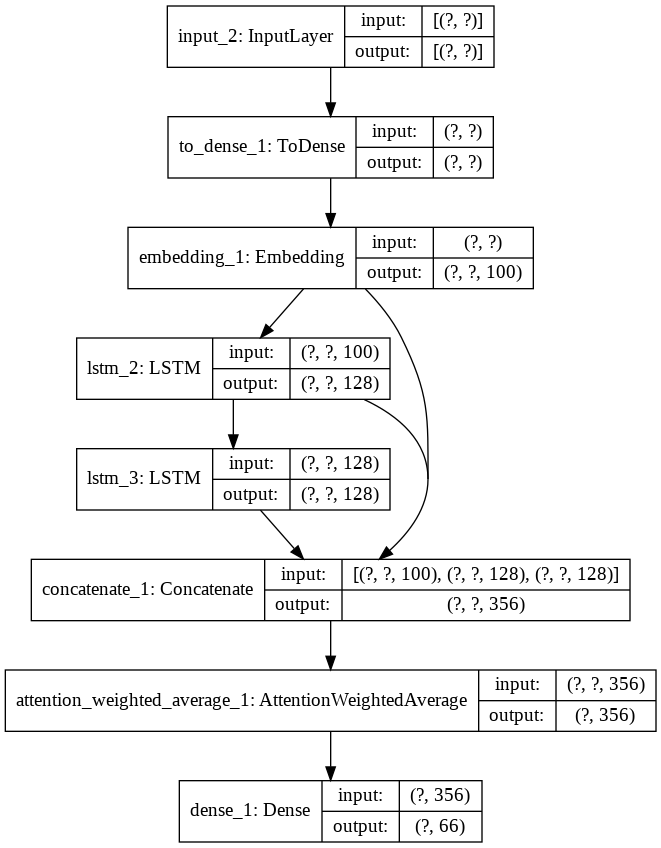

In [55]:
plot_model(model, to_file='char-rnn.png', show_shapes=True)

### Simple RNN

In [0]:
class WBCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    # logs is a dict containing the loss value, and all the metrics at the end of a batch or epoch.
    # We will simply log to W&B all the content of this dictionnary.
    wandb.log(logs)

In [0]:
model = tf.keras.Sequential([
  InputLayer(input_shape=(None,), dtype='int64', ragged=True),
  tftext.keras.layers.ToDense(pad_value=pad_val, mask=True),
  Lambda(lambda x:K.one_hot(K.cast(x,'int64'), vocab_size)),
  LSTM(lstm_output_1),
  Dense(vocab_size, activation='softmax')
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
to_dense_3 (ToDense)         (None, None)              0         
_________________________________________________________________
lambda (Lambda)              (None, None, 66)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               99840     
_________________________________________________________________
dense_3 (Dense)              (None, 66)                8514      
Total params: 108,354
Trainable params: 108,354
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[wandb_callback])

Epoch 1/10
872/872 [==============================] - 37s 43ms/step - loss: 2.6365 - accuracy: 0.2833 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
872/872 [==============================] - 27s 31ms/step - loss: 2.1208 - accuracy: 0.3934 - val_loss: 2.1026 - val_accuracy: 0.3903
Epoch 3/10
872/872 [==============================] - 27s 31ms/step - loss: 1.9788 - accuracy: 0.4264 - val_loss: 2.0265 - val_accuracy: 0.4063
Epoch 4/10
872/872 [==============================] - 27s 31ms/step - loss: 1.8910 - accuracy: 0.4481 - val_loss: 1.9781 - val_accuracy: 0.4178
Epoch 5/10
872/872 [==============================] - 27s 31ms/step - loss: 1.8274 - accuracy: 0.4641 - val_loss: 1.9456 - val_accuracy: 0.4301
Epoch 6/10
872/872 [==============================] - 27s 31ms/step - loss: 1.7758 - accuracy: 0.4774 - val_loss: 1.9138 - val_accuracy: 0.4398
Epoch 7/10
872/872 [==============================] - 27s 31ms/step - loss: 1.7335 - accuracy: 0.4887 - val_loss: 1.8841 - val_a

In [0]:
model.save(os.path.join(wandb.run.dir, "char-rnn-simple.h5"))